# 1.4 - Stopping Criteria

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
    
    # library parameters
    from rbig_jax.data import get_classic
    from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

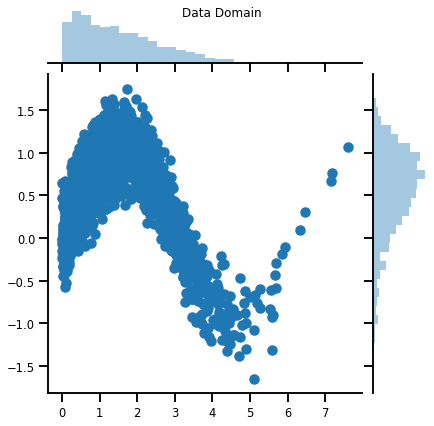

In [3]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.suptitle('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [4]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Gaussianization

In [5]:
from rbig_jax.transforms.block import get_default_rbig_block

# initialize with default block parameters
fit_transform_func, forward_f, grad_f, inverse_f = get_default_rbig_block(
    n_samples=n_samples)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

### Fixed Number of Layers

In [25]:
from chex import dataclass

@dataclass
class MaxLoss:
    ilayer: int

In [ ]:
def max

In [6]:
%%time

n_layers = 50

params = []
losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)    

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 2.44 s, sys: 49.5 ms, total: 2.49 s
Wall time: 2.42 s


<Figure size 432x288 with 0 Axes>

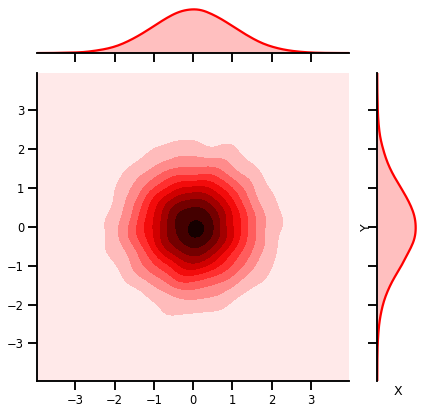

In [7]:
plot_joint(X_g, kind="kde")

## Negative Log-Likelihood

#### Loss Function

In [8]:
@jax.jit
def nll_loss(X_gauss, X_ldj):
    latent_prob = jax.scipy.stats.norm.logpdf(X_g)

    log_prob = (latent_prob + X_ldj).sum(-1)
    return - log_prob.mean()

#### Training

In [9]:
%%time

X_g_ = X
X_ldj = np.zeros_like(X)
nll_losses = []
for iparam in params:

    X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
    X_ldj += iX_ldj
    
    nll_losses.append(nll_loss(X_g_, X_ldj))
    
chex.assert_tree_all_close(X_g_, X_g)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 1 s, sys: 57.6 ms, total: 1.06 s
Wall time: 900 ms


#### Plot Losses

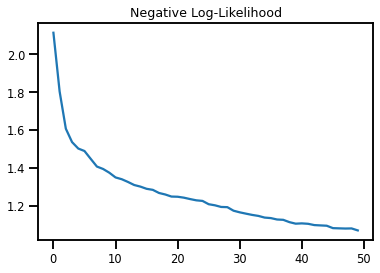

In [10]:

plt.figure()
plt.plot(nll_losses)
plt.title('Negative Log-Likelihood')
plt.show()

### Negative Log-Likelihood (Change per layer)

In [11]:
%%time

X_g_ = X
X_ldj = np.zeros_like(X)
nll_change_losses = []
for iparam in params:

    X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
    X_ldj += iX_ldj
    
    nll_change_losses.append(nll_loss(X_g_, iX_ldj))
    
chex.assert_tree_all_close(X_g_, X_g)

CPU times: user 165 ms, sys: 35.1 ms, total: 200 ms
Wall time: 43.8 ms


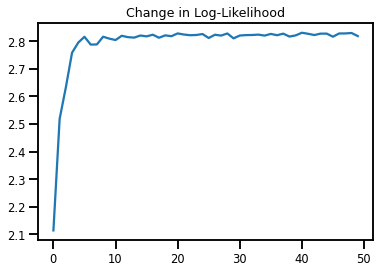

In [12]:
plt.figure()
plt.plot(nll_change_losses)
plt.title('Change in Log-Likelihood')
plt.show()

## Information Loss

#### Loss Function

In [13]:
from rbig_jax.information.total_corr import init_information_reduction_loss

In [14]:
# information reduction loss
info_loss_f = init_information_reduction_loss(n_samples=n_samples, base=2, p=0.1)


loss_f_jitted = jax.jit(info_loss_f)  # much faster!

#### Training

In [15]:
%%time

n_layers = 50

params = []
info_losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    layer_loss = jax.partial(loss_f_jitted, X_before=X_g)
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
    
    info_losses.append(layer_loss(X_after=X_g))
        
    # increment
    ilayer += 1   
    
info_losses = np.stack(info_losses)

CPU times: user 1.47 s, sys: 62.1 ms, total: 1.53 s
Wall time: 1.32 s


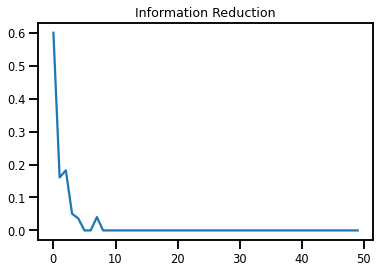

In [16]:
plt.figure()
plt.plot(info_losses)
plt.title('Information Reduction')
plt.show()

#### Total Correlation

In [17]:
total_corr = np.cumsum(info_losses)

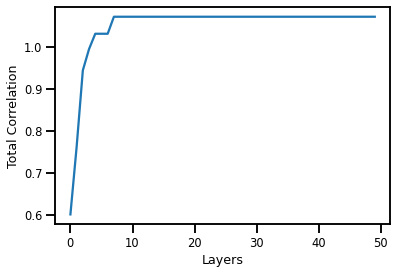

In [18]:
plt.figure()
plt.plot(total_corr)
plt.ylabel('Total Correlation')
plt.xlabel("Layers")
plt.show()

In [19]:
print(f"Total Correlation: {info_losses.sum():.4f}")

Total Correlation: 1.0715


## Optimal Gaussianization

In [22]:
%%time

n_layers = 15

params = []
info_losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    layer_loss = jax.partial(loss_f_jitted, X_before=X_g)
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
    
    info_losses.append(layer_loss(X_after=X_g))
        
    # increment
    ilayer += 1   
    
info_losses = np.stack(info_losses)

CPU times: user 98.1 ms, sys: 27.2 ms, total: 125 ms
Wall time: 35.8 ms


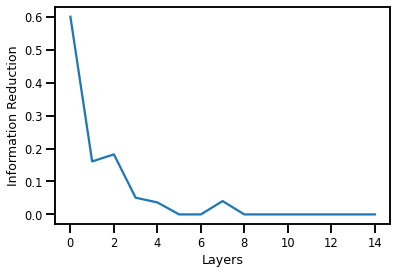

In [24]:
plt.figure()
plt.plot(info_losses)
plt.ylabel('Information Reduction')
plt.xlabel("Layers")
plt.show()